# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [9]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [10]:
# YOUR CODE HERE
from common_utils import *

def preprocess(df):
    # YOUR CODE HERE
    df.drop(columns=['filename'],inplace=True)
    X_train, y_train, X_test, y_test=split_dataset(df,columns_to_drop=['label'],test_size=0.3,random_state=42)
    #X_train_scaled,X_test_scaled=preprocess_dataset(X_train,X_test)
    return X_train, y_train, X_test, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

X_train, y_train, X_test, y_test = preprocess(df)

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size):
    # YOUR CODE HERE
    train_dataloader=DataLoader(CustomDataset(X_train_scaled,y_train),batch_size=batch_size,shuffle=True)
    test_dataloader=DataLoader(CustomDataset(X_test_scaled,y_test),batch_size=batch_size,shuffle=True)
    return train_dataloader, test_dataloader

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [11]:
def generate_cv_folds_for_batch_sizes(parameters, X, y):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict={}
    X_val_scaled_dict={}
    y_train_dict={}
    y_val_dict={}

    for batch_size in parameters:
        X_train_scaled_dict[batch_size]=[]
        X_val_scaled_dict[batch_size]=[]
        y_train_dict[batch_size]=[]
        y_val_dict[batch_size]=[]

    kf=KFold(n_splits=5,shuffle=True,random_state=42)
    for batch_size in parameters:
        for train_index,val_index in kf.split(X):
            X_train=X.iloc[train_index]
            X_val=X.iloc[val_index]
            y_train=y[train_index]
            y_val=y[val_index]

            X_train_scaled,X_val_scaled=preprocess_dataset(X_train,X_val)

            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(y_train)
            y_val_dict[batch_size].append(y_val)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128,256,512,1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [12]:
# YOUR CODE HERE
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, str):
    #for each train,val set go find batch. each batch has list of folds calc loss accuracy for each fold.
    avg_cv_accuracy={}
    time_taken={}

    model=MLP(len(df.columns)-1,[128,128,128],1)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.001)  
    early_stopper=EarlyStopper()

    for batch_size in batch_sizes:
        cv_val_accuracy=[]
        fold_time=[]

        for fold in range(5):
            X_train_scaled=X_train_scaled_dict[batch_size][fold]
            X_val_scaled=X_val_scaled_dict[batch_size][fold]
            y_train=y_train_dict[batch_size][fold]
            y_val=y_val_dict[batch_size][fold]

            train_dataloader,val_dataloader=intialise_loaders(X_train_scaled, y_train, X_val_scaled, y_val, batch_size)
            
            n_epochs=100
            
            for epoch in range(n_epochs):
                start=time.time()
                model.train()
                for i,(x,y) in enumerate(train_dataloader):
                    #forward pass
                    pred=model(x)
                    loss=loss_fn(pred.squeeze(),y)

                    #backward pass and optimise
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    #Val eval
                    overall_val_accuracy=0
                    overall_val_loss=0
                    for x,y in val_dataloader:
                        val_pred=model(x)
                        overall_val_accuracy+=(val_pred.round().squeeze()==y).float().mean()
                        overall_val_loss+=loss_fn(val_pred.squeeze(),y)

                avg_val_accuracy=(overall_val_accuracy/len(val_dataloader)).item()
                avg_val_loss=overall_val_loss/len(val_dataloader)

                #Early Stopping
                if early_stopper.early_stop(avg_val_loss):
                    fold_time.append(time.time()-start)
                    print(f'Early Stopping at epoch {epoch+1}')
                    break

                if epoch==n_epochs-1:
                    fold_time.append(time.time()-start)
    
            cv_val_accuracy.append(avg_val_accuracy)
        time_taken[batch_size]=np.array(fold_time).mean()
        avg_cv_accuracy[batch_size]=np.array(cv_val_accuracy).mean()
    return avg_cv_accuracy,time_taken
batch_sizes = [128,256,512,1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


Early Stopping at epoch 17
Early Stopping at epoch 6
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 6
Early Stopping at epoch 6
Early Stopping at epoch 1
Early Stopping at epoch 5
Early Stopping at epoch 1
Early Stopping at epoch 6
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 1
Early Stopping at epoch 5


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

Text(0.5, 1.0, 'Cross-Validation accuracy against Batch size')

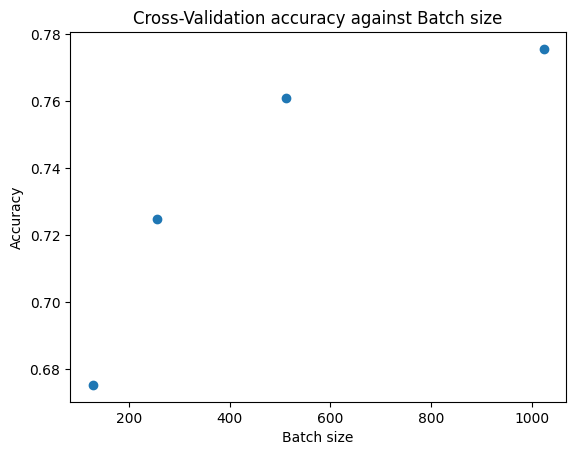

In [13]:
# YOUR CODE HERE
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Cross-Validation accuracy against Batch size")

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [14]:
df=pd.DataFrame(cross_validation_times.items(), columns=['Batch Size','Time Taken'])
df

,Batch Size,Time Taken
0,128,0.163877
1,256,0.145893
2,512,0.123209
3,1024,0.127457


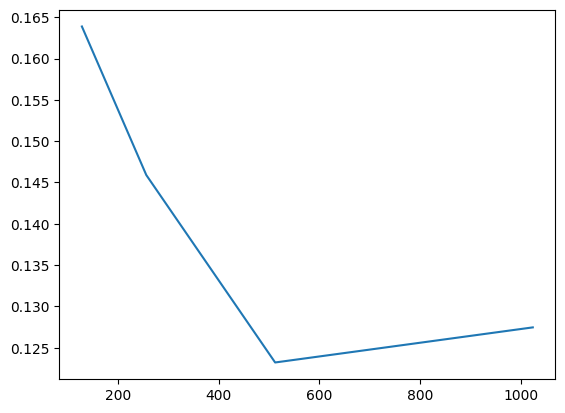

In [15]:
plt.plot(df['Batch Size'],df['Time Taken'])

In [16]:
# YOUR CODE HERE
optimal_batch_size =512
reason ='''There is a significant decrease in training time from batch size 128->256->512 
           but vey minimal decrease in training time from batch size 512 onwards.'''